# <font color = 'indianred'>**MultiLabel Classification with DistilBert** </font>


## Outline
1. **Setting up the Environment**: Installing necessary libraries and setting up paths.
2. **Creating Huggingface Dataset for Custom Dataset**: Understanding the structure and content of the dataset.

3. **Data Preprocessing**: Techniques to prepare the data for training, including handling different data splits and tokenization
4. **Training the Model**: Feeding data and adjusting weights.
5. **Inference**: Evaluate model on test set and making predictions.



# <font color = 'indianred'> **Setting up the Environment** </font>



In [1]:
 # CHANGE FOLDERS AS PER YOUR SETUP
from pathlib import Path
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount("/content/drive")
    !pip install datasets transformers evaluate wandb accelerate -U -qq
    base_folder = Path("/content/drive/MyDrive/data")
else:
    base_folder = Path("/home/harpreet/Insync/google_drive_shaannoor/data")



In [2]:
from transformers import AutoConfig, AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
from transformers import  DataCollatorWithPadding, pipeline
from datasets import load_dataset, DatasetDict, Dataset
import evaluate

import torch
from torch.utils.data import DataLoader

import wandb

import numpy as np
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer   
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import random

import textwrap
import joblib
import ast

2023-10-09 05:29:59.004450: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# CHANGE FOLDERS TO WHERE YOU WANT TO SAVE DATA AND MODELS
data_folder = base_folder/'datasets/Classification_HW/joblib_files'
model_folder = base_folder/'models/nlp_fall_2023/multilabel'
model_folder.mkdir(exist_ok=True)

In [4]:
def print_wrap(text, d):
    # Wrap the text to limit the width to 'd'
    wrapped_text = textwrap.fill(text, width=d)

    # Print the wrapped text
    print(wrapped_text)

# <font color = 'indianred'> **Exploring and Understanding Dataset**

## <font color = 'indianred'> **Stack Exchange MultiLabel Dataset**</font>

- In this HW, you will identify tags for stack exchange Questions.
- This data is a subset of data available in a Kaggle Competition.
- The given dataset has different questions asked in the StackExchange website for various technical domains.
- We have fetched only those questions that contain the top 10 individual tags.
- **Each question have more than one tag. This means that this is a <font color = "indianred">multi-label classification problem.**</font>
- These are the ten categories for tags in the data.

<div style="margin-left:5%">


| Index| Tag  |
|:-------:|:-------------:|
| 0     | C#          |
| 1     | java        |
| 2     | php         |
| 3     | javascript  |
| 4     | android     |
| 5     | jquery      |
| 6     | c++         |
| 7     | python      |
| 8     | iphone      |
| 9     | asp.net     |

</div>

## <font color = 'indianred'> **Load Data set**
    


In [5]:
# The file 'multiclass_hw_basic_clean.csv' is availaible on eLearing 0_data_Folder
# Make sure that you specify teh correct path
# The file name need to be in teh string, thaat is why we have used str(file_path)
# We loaded imdb dataset from huggingface
# in this case we are creating a hugginmgface dataset from csv file
df = joblib.load(data_folder/'df_multilabel_hw_cleaned.joblib')
df

,cleaned_text,Tags,Tag_Number
0,asp query stre dropdown webpage follow control...,c# asp.net,"[0, 9]"
1,run javascript code server java code want run ...,java javascript,"[1, 3]"
2,linq sql throw exception row find change hi li...,c# asp.net,"[0, 9]"
3,run python script php server run nginx web ser...,php python,"[2, 7]"
4,advice write function m try write function res...,javascript jquery,"[3, 5]"
...,...,...,...
47422,take value edittext put decimal point all- wor...,java android,"[1, 4]"
47423,listen phone state application nee liste phone...,java android,"[1, 4]"
47424,android ui thread thread task want access main...,java android,"[1, 4]"
47425,dynamic table row creation html javascript htm...,asp.net javascript,"[9, 3]"


In [6]:
stack_dataset = Dataset.from_pandas(df)

## <font color = 'indianred'> **Understanding your data**

In [7]:
print(stack_dataset)

Dataset({
    features: ['cleaned_text', 'Tags', 'Tag_Number'],
    num_rows: 47427
})


## <font color = 'indianred'> **Understanding the datatype of columns**


In [8]:
stack_dataset.features


{'cleaned_text': Value(dtype='string', id=None),
 'Tags': Value(dtype='string', id=None),
 'Tag_Number': Value(dtype='string', id=None)}

## <font color = 'indianred'> **Acess indivdual element** </font>


In [9]:
# get the first example of the dataset
stack_dataset[1]


{'cleaned_text': 'run javascript code server java code want run javascript code server want manipulate result return javascript inside java code',
 'Tags': 'java javascript',
 'Tag_Number': '[1, 3]'}

In [10]:
print_wrap(stack_dataset['cleaned_text'][0], 80)

asp query stre dropdown webpage follow control relevance    dropdownlist value
hyperlink redirect page call   page cancel button redirect user menu page like
user click hyperlink edit page index dropdownlist preserve query string page
follow aspx code sure proceed < asp hyperlink      id="lnkedit
navigateurl='<% + eval("userid + sure > < /asp hyperlink >   < asp dropdownlist
id="mydropdown      < asp listitems/ > < /asp dropdownlist >   edit clarify m
navigateurl query string eval determine user id


In [11]:
# get label of last ten examples
stack_dataset['Tag_Number'][-10:]

['[1, 4]',
 '[3, 5]',
 '[5, 9]',
 '[3, 5]',
 '[1, 7]',
 '[1, 4]',
 '[1, 4]',
 '[1, 4]',
 '[9, 3]',
 '[3, 5]']

In [12]:
stack_dataset['Tags'][-10:]

['java android',
 'javascript jquery',
 'jquery asp.net',
 'javascript jquery',
 'java python',
 'java android',
 'java android',
 'java android',
 'asp.net javascript',
 'javascript jquery']

In [13]:
# Assuming 'stack_dataset' is a huggingface dataset
# Select only the desired columns and rename them
selected_columns = {
    'text': stack_dataset['cleaned_text'],
    'tag': stack_dataset['Tag_Number']
}

# Create a new dataset with the selected columns
stack_selected_columns = Dataset.from_dict(selected_columns)


In [14]:
stack_selected_columns

Dataset({
    features: ['text', 'tag'],
    num_rows: 47427
})

In [15]:
stack_selected_columns.features

{'text': Value(dtype='string', id=None), 'tag': Value(dtype='string', id=None)}

In [16]:
stack_selected_columns['tag'][:10]

['[0, 9]',
 '[1, 3]',
 '[0, 9]',
 '[2, 7]',
 '[3, 5]',
 '[3, 5]',
 '[2, 3]',
 '[0, 9]',
 '[3, 5]',
 '[1, 4]']

In [17]:
print_wrap(stack_selected_columns['text'][0], 80)

asp query stre dropdown webpage follow control relevance    dropdownlist value
hyperlink redirect page call   page cancel button redirect user menu page like
user click hyperlink edit page index dropdownlist preserve query string page
follow aspx code sure proceed < asp hyperlink      id="lnkedit
navigateurl='<% + eval("userid + sure > < /asp hyperlink >   < asp dropdownlist
id="mydropdown      < asp listitems/ > < /asp dropdownlist >   edit clarify m
navigateurl query string eval determine user id


## <font color = 'indianred'> **Exploratory Data Analysis (EDA)**

### <font color = 'indianred'> **Change dataset format to Pandas**  </font>


In [18]:
# Set the format to Pandas
stack_selected_columns.set_format(type='pandas') 

In [19]:
# get all rows the dataset
df = stack_selected_columns[:]


In [20]:
df.head()

,text,tag
0,asp query stre dropdown webpage follow control...,"[0, 9]"
1,run javascript code server java code want run ...,"[1, 3]"
2,linq sql throw exception row find change hi li...,"[0, 9]"
3,run python script php server run nginx web ser...,"[2, 7]"
4,advice write function m try write function res...,"[3, 5]"


In [21]:
df['tag_mod'] = df['tag'].apply(lambda x: ast.literal_eval(x))

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47427 entries, 0 to 47426
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     47427 non-null  object
 1   tag      47427 non-null  object
 2   tag_mod  47427 non-null  object
dtypes: object(3)
memory usage: 1.1+ MB


### <font color = 'indianred'> **Visualize distribution of class labels** </font>
It is important to undetrstand the distribution of the class labels to check if there is any imbalance among the categories.

In [23]:
df['tag_mod'][0:10]

0    [0, 9]
1    [1, 3]
2    [0, 9]
3    [2, 7]
4    [3, 5]
5    [3, 5]
6    [2, 3]
7    [0, 9]
8    [3, 5]
9    [1, 4]
Name: tag_mod, dtype: object

In [24]:
# check distribution of class labels in the dataset
print(df['tag_mod'].explode().value_counts())

tag_mod
3    27357
5    25038
9    12466
0    10451
1     8307
4     7607
2     5732
6      759
7      587
8      315
Name: count, dtype: int64


In [25]:
print(df['tag_mod'].value_counts())

tag_mod
[3, 5]             19989
[0, 9]              7986
[1, 4]              6922
[2, 3]              2165
[2, 5]              1499
                   ...  
[0, 2, 3, 9, 5]        1
[3, 9, 4]              1
[2, 3, 8]              1
[1, 2, 8, 6, 4]        1
[3, 2]                 1
Name: count, Length: 176, dtype: int64


In [26]:
df['tag_mod'].value_counts().head(10)

tag_mod
[3, 5]       19989
[0, 9]        7986
[1, 4]        6922
[2, 3]        2165
[2, 5]        1499
[2, 3, 5]     1136
[3, 9]        1058
[5, 9]         701
[0, 3, 9]      648
[3, 5, 9]      430
Name: count, dtype: int64

### <font color = 'indianred'> **Check length of the reviews** </font>


In [27]:
# Add empty strings for rows atht do not have any text
df['text'] = df['text'].fillna('')

In [28]:
# Calculate words per review
df['words_per_review'] = df['text'].str.split().apply(len) # CODE HERE


In [29]:
df.head()

,text,tag,tag_mod,words_per_review
0,asp query stre dropdown webpage follow control...,"[0, 9]","[0, 9]",74
1,run javascript code server java code want run ...,"[1, 3]","[1, 3]",19
2,linq sql throw exception row find change hi li...,"[0, 9]","[0, 9]",91
3,run python script php server run nginx web ser...,"[2, 7]","[2, 7]",51
4,advice write function m try write function res...,"[3, 5]","[3, 5]",63


#### <font color = 'indianred'> **Plot the distribution of review length** </font>

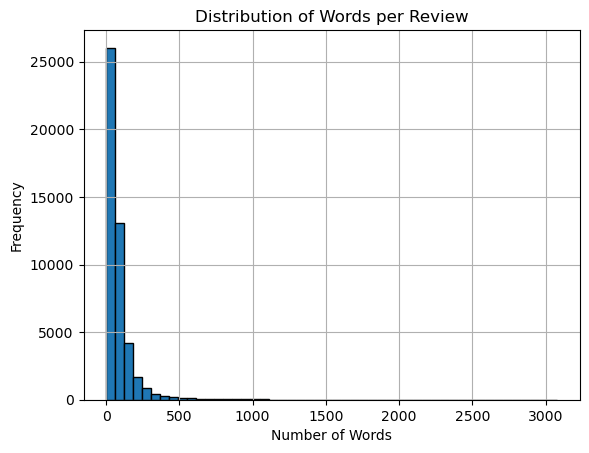

In [30]:
# Plot a histogram of the 'words_per_review' column
df['words_per_review'].hist(bins=50, edgecolor='black')

# Adding labels and a title for clarity
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Distribution of Words per Review')

# Display the plot
plt.show()


In [31]:
# The model we are going to use has token (subwords) limit of 512.
# Let us check how many reviews has more than 500 words

count = (df['words_per_review'] > 500).sum()
print(f"Number of reviews with more than 400 words: {count}")


Number of reviews with more than 400 words: 553


In [32]:
# count the rows that do not have any text
count = (df['words_per_review'] ==0).sum()
print(f"Number of reviews with no text words: {count}")

Number of reviews with no text words: 3


In [33]:
# check the rows that have less than 20 words
count = (df['words_per_review'] <20).sum()
print(f"Number of reviews with less than 20 words: {count}")

Number of reviews with less than 20 words: 3484


In [34]:
# distribution of number of words for each class label
exploded_df = df.explode('tag_mod')


In [35]:
exploded_df

,text,tag,tag_mod,words_per_review
0,asp query stre dropdown webpage follow control...,"[0, 9]",0,74
0,asp query stre dropdown webpage follow control...,"[0, 9]",9,74
1,run javascript code server java code want run ...,"[1, 3]",1,19
1,run javascript code server java code want run ...,"[1, 3]",3,19
2,linq sql throw exception row find change hi li...,"[0, 9]",0,91
...,...,...,...,...
47424,android ui thread thread task want access main...,"[1, 4]",4,14
47425,dynamic table row creation html javascript htm...,"[9, 3]",9,36
47425,dynamic table row creation html javascript htm...,"[9, 3]",3,36
47426,image preloader work ie follow code preload im...,"[3, 5]",3,78


<Axes: title={'center': 'words_per_review'}, xlabel='tag_mod'>

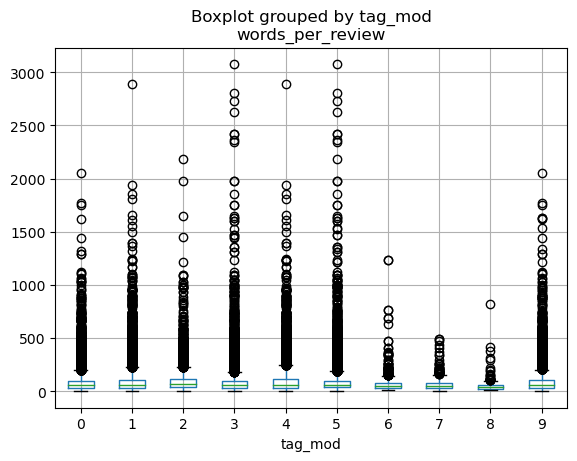

In [36]:
exploded_df.boxplot('words_per_review', by='tag_mod')

- From the above graph, it seems that the distribution of number of words is similar for all the classes.
- Most models have max sequence length of 512. We have less than 1% observatins that have more than 512 words.

In [37]:
stats_df = exploded_df.groupby('tag_mod')['words_per_review'].agg(['mean', 'std', 'min', 'max'])


In [38]:
stats_df

,mean,std,min,max
tag_mod,,,,
0,85.608459,107.438474,1,2057
1,102.018298,144.700352,4,2891
2,96.743371,114.172148,1,2181
3,80.049786,99.715367,0,3079
4,106.862101,148.981024,5,2891
5,83.369239,105.822177,0,3079
6,71.820817,101.228820,7,1237
7,65.534923,63.168690,3,491
8,52.171429,63.846870,7,817


In [39]:
label_encoder = MultiLabelBinarizer()

In [40]:
df['label'] = list(label_encoder.fit_transform(df['tag_mod']))

In [41]:
df['tag_mod'][0:5]

0    [0, 9]
1    [1, 3]
2    [0, 9]
3    [2, 7]
4    [3, 5]
Name: tag_mod, dtype: object

In [42]:
df['label'][0:5]

0    [1, 0, 0, 0, 0, 0, 0, 0, 0, 1]
1    [0, 1, 0, 1, 0, 0, 0, 0, 0, 0]
2    [1, 0, 0, 0, 0, 0, 0, 0, 0, 1]
3    [0, 0, 1, 0, 0, 0, 0, 1, 0, 0]
4    [0, 0, 0, 1, 0, 1, 0, 0, 0, 0]
Name: label, dtype: object

In [43]:
df_final = df[['text', 'label']]

In [44]:
df_final.head(3)

,text,label
0,asp query stre dropdown webpage follow control...,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
1,run javascript code server java code want run ...,"[0, 1, 0, 1, 0, 0, 0, 0, 0, 0]"
2,linq sql throw exception row find change hi li...,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 1]"


### <font color = 'indianred'> **Reset dataset format** </font>


In [45]:
# reset the format back to huggingface dataset
stack_selected_columns_final = Dataset.from_pandas(df_final)


In [46]:
stack_selected_columns_final

Dataset({
    features: ['text', 'label'],
    num_rows: 47427
})

# <font color = 'indianred'> **Data Pre-processing**</font>

### <font color = 'indianred'> **Create train, valid, test splits** </font>

In [47]:
# We know this information from how we created this dataset
class_names = ['c#', 'java', 'php','javascript', 'android', 'jquery', 'c++',  'python', 'iphone', 'asp.net']

In [48]:
# Cast the 'label' column of stack_selected_columns to the ClassLabel type with specified class names from class_names.
# stack_selected_columns_final = stack_selected_columns_final.cast_column('label', ClassLabel(names = class_names))


In [49]:
test_val_splits = stack_selected_columns_final.train_test_split(test_size=0.4, seed=42) # we cannot do stratify_by_column='label'
train_split= test_val_splits['train'] 
test_val_splits = test_val_splits['test'].train_test_split(test_size=0.5, seed=42,) # we cannot do stratify_by_column='label') 
val_split = test_val_splits['train'] 
test_split = test_val_splits['test'] 


### <font color = 'indianred'> **Create small subset for experimentation** </font>

The code below creates a new dataset, train_val_subset, with subsets of the original train_val_dataset. For each split ('train' and 'val'), it ensures an equal representation of 200 samples from each label (0-9). The balanced subsets are then stored in the respective splits of train_val_subset.

In [50]:
# train_val_subset = DatasetDict()

# for split in ['train', 'val']:
#   texts = []
#   labels = []
#   for label in range(10):
#     label_texts = train_val_dataset[split].filter(lambda x: x['label'] == label)['text']
#     label_subset = random.sample(list(label_texts), 200)
#     texts.extend(label_subset)
#     labels.extend([label]*len(label_subset))

#   train_val_subset[split] = Dataset.from_dict({'text': texts, 'label': labels})

In [51]:
train_split_small = train_split.shuffle(seed=42).select(range(2000))
val_split_small = val_split.shuffle(seed=42).select(range(500))
test_split_small = test_split.shuffle(seed=42).select(range(500))

In [52]:
# combine train, val splits into one dataset
train_val_dataset = DatasetDict({'train': train_split, 'val': val_split})

# create test dataset from test split
test_dataset = DatasetDict({'test': test_split})

# create subsets of train and val datasets
train_val_subset = DatasetDict({'train': train_split_small, 'val': val_split_small})

# create subset for test dataset
test_subset = DatasetDict({'test': test_split_small})



In [53]:
train_val_subset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    val: Dataset({
        features: ['text', 'label'],
        num_rows: 500
    })
})

In [54]:
# Retrieve the feature structures (data types and associated details) of the 'train' split from train_val_subset.
train_val_subset['train'].features


{'text': Value(dtype='string', id=None),
 'label': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)}

## <font color = 'indianred'> **Tokenization**</font>



In [55]:
# Define a checkpoint for the DistilBERT model with an uncased vocabulary.
# Instantiate the tokenizer for this model using the specified checkpoint.
checkpoint = "distilbert-base-uncased" # CODE HERE
tokenizer = AutoTokenizer.from_pretrained(checkpoint) # CODE HERE



###  <font color = 'indianred'> **Understanding pre-trained Tokenizer**
We will now understand how the tokenizer work by feeding one simple example.

In [56]:
text = ["Tokenization is the process of splitting sequence to tokens",
        "I like BUAN6482"]

In [57]:
# get the vocab size
print(f'Pretrained tokenizer vocab size {tokenizer.vocab_size}')


Pretrained tokenizer vocab size 30522


In [58]:
encoded_text = tokenizer(
    text, padding=True, truncation=True, return_tensors='pt')

In [59]:
encoded_text

{'input_ids': tensor([[  101, 19204,  3989,  2003,  1996,  2832,  1997, 14541,  5537,  2000,
         19204,  2015,   102],
        [  101,  1045,  2066, 20934,  2319, 21084,  2620,  2475,   102,     0,
             0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]])}

What is the difference from ```bert-base-uncased``` tokenizer?

- ```distilbert-base-uncased``` do not have token-type-ids

In [60]:
tokens_first_sentence = tokenizer.convert_ids_to_tokens(
    encoded_text.input_ids[0])
tokens_second_sentence = tokenizer.convert_ids_to_tokens(
    encoded_text.input_ids[1])

print(tokens_first_sentence)
print(tokens_second_sentence)

['[CLS]', 'token', '##ization', 'is', 'the', 'process', 'of', 'splitting', 'sequence', 'to', 'token', '##s', '[SEP]']
['[CLS]', 'i', 'like', 'bu', '##an', '##64', '##8', '##2', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


In [61]:
tokenizer.convert_tokens_to_string(tokens_first_sentence)

'[CLS] tokenization is the process of splitting sequence to tokens [SEP]'

In [62]:
tokenizer.convert_tokens_to_string(tokens_second_sentence)

'[CLS] i like buan6482 [SEP] [PAD] [PAD] [PAD] [PAD]'

In [63]:
special_tokens = tokenizer.all_special_tokens
special_tokens_ids = tokenizer.all_special_ids
print(special_tokens, special_tokens_ids)

['[UNK]', '[SEP]', '[PAD]', '[CLS]', '[MASK]'] [100, 102, 0, 101, 103]


###  <font color = 'indianred'> **Create function for Tokenizer**

In [64]:
# Define a function to tokenize the text in a batch using the predefined tokenizer.
# The text data is extracted from the "text" key of the batch.
# The function will truncate the tokenized data if it exceeds the tokenizer's maximum length.

def tokenize_fn(batch):
    return tokenizer(batch["text"], truncation=True)


###  <font color = 'indianred'> **Use map function to apply tokenization to all splits**

In [65]:
# Map the tokenize_fn function over the entire train_val_subset dataset in batches.
# This will tokenize the text data in each batch and return a new dataset with tokenized data.
tokenized_dataset = train_val_subset.map(tokenize_fn, batched=True) # CODE HERE


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [66]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    val: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 500
    })
})

We can see that tokenization step has added three new columns ('input_ids', 'token_type_ids', 'attention_mask') to the dataset

In [67]:
tokenized_dataset = tokenized_dataset.remove_columns(
    ['text']
)

In [68]:
tokenized_dataset 

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    val: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 500
    })
})

###  <font color = 'indianred'> **Cast Label Ids to Floats**

In [69]:
tokenized_dataset.set_format(type='torch')
tokenized_dataset = (tokenized_dataset
          .map(lambda x : {"float_label": x["label"].to(torch.float)}, remove_columns=["label"])
          .rename_column("float_label", "label"))

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [70]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'label'],
        num_rows: 2000
    })
    val: Dataset({
        features: ['input_ids', 'attention_mask', 'label'],
        num_rows: 500
    })
})

In [71]:
tokenized_dataset['train'].features

{'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None),
 'label': Sequence(feature=Value(dtype='float32', id=None), length=-1, id=None)}

In [72]:
tokenized_dataset['train']['label'][0:3]

tensor([[0., 0., 0., 1., 0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 1., 0., 0., 0., 0., 0., 0.]])

In [73]:
print(len(tokenized_dataset["train"]["input_ids"][2]))
print(len(tokenized_dataset["train"]["input_ids"][1]))

512
83


The varying lengths in the dataset indicate that padding has not been applied yet. Instead of padding the entire dataset, we prefer processing small batches during training. Padding is done selectively for each batch based on the maximum length in the batch. We will discuss this in more detail in a later section of this notebook.

#  <font color = 'indianred'> **Model Training**

##  <font color = 'indianred'> **Model Config File**

##  <font color = 'indianred'> **Download pre-trained model**

In [74]:
# Instantiate a model for sequence classification using the specified checkpoint.
# The provided configuration (config) ensures the model aligns with the structure and settings of the original checkpoint.
# Use AutoModelForSequenceClassification
# Pass the checkpoint and config
num_labels=10
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=num_labels,
                                                           problem_type="multi_label_classification").to('cuda')


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [75]:
model.config

DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8,
    "LABEL_9": 9
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "multi_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.32.0",
  "vocab_size":

###  <font color = 'indianred'> **Modify Configuration File**</font>
- We need to modify configuration fie to add ids to  label and label to ids mapping
- Adding id2label and label2id to the configuration file provides a consistent, interpretable, and user-friendly way to handle model outputs.

In [76]:
class_names


['c#',
 'java',
 'php',
 'javascript',
 'android',
 'jquery',
 'c++',
 'python',
 'iphone',
 'asp.net']

In [77]:
id2label = {}
for id_, label_ in enumerate(class_names):
    id2label[str(id_)] = label_
id2label


{'0': 'c#',
 '1': 'java',
 '2': 'php',
 '3': 'javascript',
 '4': 'android',
 '5': 'jquery',
 '6': 'c++',
 '7': 'python',
 '8': 'iphone',
 '9': 'asp.net'}

In [78]:
label2id = {}
for id_, label_ in enumerate(class_names):
    label2id[label_] = id_
label2id


{'c#': 0,
 'java': 1,
 'php': 2,
 'javascript': 3,
 'android': 4,
 'jquery': 5,
 'c++': 6,
 'python': 7,
 'iphone': 8,
 'asp.net': 9}

In [79]:
model.config.id2label = id2label
model.config.label2id = label2id

In [80]:
model.config


DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "c#",
    "1": "java",
    "2": "php",
    "3": "javascript",
    "4": "android",
    "5": "jquery",
    "6": "c++",
    "7": "python",
    "8": "iphone",
    "9": "asp.net"
  },
  "initializer_range": 0.02,
  "label2id": {
    "android": 4,
    "asp.net": 9,
    "c#": 0,
    "c++": 6,
    "iphone": 8,
    "java": 1,
    "javascript": 3,
    "jquery": 5,
    "php": 2,
    "python": 7
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "multi_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.32.0",
  "vocab_size": 30522
}

## <font color = 'indianred'> **Model Input/Collate Function** </font>

In [81]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [82]:
features = [tokenized_dataset["train"][i] for i in range(2)]

In [83]:
features

[{'input_ids': tensor([  101, 10086,  4957,  2173,  2224,  9262, 22483, 10086,  3793,  2173,
           2342, 10086,  4957, 11562,  4957,  2612,  2191, 10086,  3085,  2417,
           7442,  6593,  4957,  4769,  2689,  3313, 11562,  4957, 10086,  3085,
           2417,  7442,  6593,  2393,   102]),
  'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
  'label': tensor([0., 0., 0., 1., 0., 1., 0., 0., 0., 0.])},
 {'input_ids': tensor([  101, 11924,  2265, 27427, 15141, 19269,  5082,  3347, 21628, 15006,
           2102,  4023,  2113,  3582,  3642,  5342,  4714,  8206,  5082,  3347,
           3582,  3642, 11924,  5227, 11101,  5004,  7959,  4017,  5397,  1006,
           3332,  3444,  1035, 27427, 15141, 19269,  1035,  5082,  2275, 21572,
          17603,  4757, 25990, 13629,  3334, 19269, 11365, 13464,  1006,  2995,
           2275, 21572, 17603,  4757, 25990, 13629,  3334, 19269, 11365, 13464,


In [84]:
model_input = data_collator(features)
model_input.keys()

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


dict_keys(['input_ids', 'attention_mask', 'labels'])

In [85]:
print(model_input.input_ids[0][0:10])
print(model_input.input_ids[0][-20:])
print(model_input.input_ids[1][0:10])
print(model_input.input_ids[1][-20:])

tensor([  101, 10086,  4957,  2173,  2224,  9262, 22483, 10086,  3793,  2173])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([  101, 11924,  2265, 27427, 15141, 19269,  5082,  3347, 21628, 15006])
tensor([21628, 15006,  2102,  2342,  2583,  2775,  4023,  2126,  2424,  3160,
        20014,  2906,  8545,  5910,  2175, 14477,  3619, 13777,  2098,   102])


In [86]:
print(model_input.attention_mask[0][-20:])
print(model_input.attention_mask[1][-20:])

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])


In [87]:
print(tokenizer.convert_ids_to_tokens(model_input.input_ids[0][0:10]))

['[CLS]', 'edit', 'link', 'place', 'use', 'java', '##script', 'edit', 'text', 'place']


In [88]:
print(tokenizer.convert_ids_to_tokens(model_input.input_ids[0][-10:]))

['[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


In [89]:
print(tokenizer.convert_ids_to_tokens(model_input.input_ids[1][0:10]))

['[CLS]', 'android', 'show', 'ind', '##eter', '##minate', 'progress', 'bar', 'tab', '##hos']


In [90]:
print(tokenizer.convert_ids_to_tokens(model_input.input_ids[1][-10:]))

['int', '##ar', '##we', '##bs', 'go', 'una', '##ns', '##wer', '##ed', '[SEP]']


##  <font color = 'indianred'> **Understanding Model Output**

In [91]:
# model output
model=model.to(device=0)
model_input= model_input.to(device=0)
model.train()
model_output = model(**model_input)

In [92]:
# keys in model output
model_output.keys()

odict_keys(['loss', 'logits'])

In [93]:
# let us look at logits
model_output.logits


tensor([[-0.1357, -0.0123, -0.0282,  0.0685,  0.0302,  0.0071,  0.0988,  0.0412,
          0.0148,  0.1257],
        [-0.0447,  0.0999,  0.1092,  0.1348, -0.0315, -0.0167,  0.1395, -0.0215,
          0.0997, -0.0380]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [94]:
model_output.logits.shape

torch.Size([2, 10])

In [95]:
model_output.loss

tensor(0.7028, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

##  <font color = 'indianred'> **Evaluation metric(s)** </font>

### <font color = 'indianred'> **Function to compute metric** </font>

## NOTE The DIFFERENCE BETWEEN THIS FUNCTION AND THE SAME FUNBCTION WE CREATED FOR IMDB DATASET

- evaluate.combine and combined_metrics.compute does not work for multiclass classification. This is a known bug that might get resolved in future versions of evaluate

In [96]:
# Define a function to compute evaluation metrics for sequence classification.
# The function takes in the evaluation predictions which consist of logits and true labels.
# The function calculates the macro F1 score and accuracy, and returns them as a dictionary.


def compute_metrics(eval_pred):
    # Split the evaluation predictions into logits (model predictions) and actual labels.
    logits, labels = eval_pred
    labels = labels.astype(int)  # Convert labels to integer type
    
    # Convert logits to binary predictions.
    predictions = (logits > 0).astype(int)

    # Flatten the predictions and labels for metric computation.
    flat_predictions = predictions.flatten()
    flat_labels = labels.flatten()

    # Load the metrics
    f1_macro_metric = evaluate.load("f1", average="macro")
    f1_micro_metric = evaluate.load("f1", average="micro")


    # Compute macro F1 score
    macro_f1 = f1_macro_metric.compute(predictions=flat_predictions, references=flat_labels, average="macro")

    # Compute micro F1 score
    micro_f1 = f1_micro_metric.compute(predictions=flat_predictions, references=flat_labels, average="micro")

    # Compute label-wise accuracies
    correct_predictions = (predictions == labels).sum(axis=0)
    total_predictions = predictions.shape[0]
    label_accuracies = correct_predictions / total_predictions
    
    # Compute the average label accuracy
    avg_label_accuracy = np.mean(label_accuracies)

    # Compute accuracy where all labels for an observation need to be correct
    correct_observations = np.all(predictions == labels, axis=1).sum()
    all_accuracy = correct_observations / total_predictions

    # Combine results
    evaluations = {
        'macro_f1': macro_f1['f1'],
        'micro_f1': micro_f1['f1'],
        'accuracy_all': all_accuracy,
        'avg_label_accuracy': avg_label_accuracy
    }

    return evaluations




## <font color = 'indianred'> **Set up Logger for experiments**</font>

In [96]:
# YOU WILL NEED TO CREATE AN ACCOUNT FOR WANDB
# It may provide a link for token , copy paste the token following instructions
# setup wandb
wandb.login()  # you will need to craete wandb account first
# Set project name for logging
%env WANDB_PROJECT = nlp_course_fall_2023-multilabel

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: hsingh-utd. Use `wandb login --relogin` to force relogin


env: WANDB_PROJECT=nlp_course_fall_2023-multilabel


## <font color = 'indianred'> **Hyperparameters and Checkpointing**</font>

In [97]:
# Define the directory where model checkpoints will be saved
model_folder = base_folder / "models"/"nlp_fall_2023/multilabel/dbert"
# Create the directory if it doesn't exist
model_folder.mkdir(exist_ok=True, parents=True)

# Configure training parameters
training_args = TrainingArguments(
    # Training-specific configurations
    num_train_epochs=2,  # Total number of training epochs
    # Number of samples per training batch for each device
    per_device_train_batch_size=16,
    # Number of samples per evaluation batch for each device
    per_device_eval_batch_size=16,
    weight_decay=0.01,  # Apply L2 regularization to prevent overfitting
    learning_rate=2e-5,  # Step size for the optimizer during training
    optim='adamw_torch',  # Optimizer,

    # Checkpoint saving and model evaluation settings
    output_dir=str(model_folder),  # Directory to save model checkpoints
    evaluation_strategy='steps',  # Evaluate model at specified step intervals
    eval_steps=20,  # Perform evaluation every 10 training steps
    save_strategy="steps",  # Save model checkpoint at specified step intervals
    save_steps=20,  # Save a model checkpoint every 10 training steps
    load_best_model_at_end=True,  # Reload the best model at the end of training
    save_total_limit=2,  # Retain only the best and the most recent model checkpoints
    # Use 'accuracy' as the metric to determine the best model
    metric_for_best_model="macro_f1",
    greater_is_better=True,  # A model is 'better' if its accuracy is higher


    # Experiment logging configurations (commented out in this example)
    logging_strategy='steps',
    logging_steps=20,
    report_to='wandb',  # Log metrics and results to Weights & Biases platform
    run_name= 'mlabel_exp1',  # Experiment name for Weights & Biases
)


##  <font color = 'indianred'> **Initialize Trainer**</font>

In [98]:
# initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["val"],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)


##  <font color = 'indianred'> **Start Training**

In [99]:
trainer.data_collator

DataCollatorWithPadding(tokenizer=DistilBertTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True), padding=True, max_length=None, pad_to_multiple_of=None, return_tensors='pt')

In [100]:
trainer.train()  # start training


  0%|          | 0/250 [00:00<?, ?it/s]

{'loss': 0.588, 'learning_rate': 1.8400000000000003e-05, 'epoch': 0.16}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.49467945098876953, 'eval_macro_f1': 0.6338954986419739, 'eval_micro_f1': 0.8083999999999999, 'eval_accuracy_all': 0.0, 'eval_avg_label_accuracy': 0.8084, 'eval_runtime': 5.2613, 'eval_samples_per_second': 95.034, 'eval_steps_per_second': 6.082, 'epoch': 0.16}
{'loss': 0.4585, 'learning_rate': 1.6800000000000002e-05, 'epoch': 0.32}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.4349927306175232, 'eval_macro_f1': 0.7050963057745774, 'eval_micro_f1': 0.831, 'eval_accuracy_all': 0.256, 'eval_avg_label_accuracy': 0.8309999999999998, 'eval_runtime': 5.319, 'eval_samples_per_second': 94.003, 'eval_steps_per_second': 6.016, 'epoch': 0.32}
{'loss': 0.4319, 'learning_rate': 1.5200000000000002e-05, 'epoch': 0.48}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.4098471701145172, 'eval_macro_f1': 0.711904088478716, 'eval_micro_f1': 0.8334, 'eval_accuracy_all': 0.282, 'eval_avg_label_accuracy': 0.8333999999999999, 'eval_runtime': 5.1691, 'eval_samples_per_second': 96.729, 'eval_steps_per_second': 6.191, 'epoch': 0.48}
{'loss': 0.3958, 'learning_rate': 1.3600000000000002e-05, 'epoch': 0.64}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.3894563913345337, 'eval_macro_f1': 0.7224142855961642, 'eval_micro_f1': 0.8402, 'eval_accuracy_all': 0.302, 'eval_avg_label_accuracy': 0.8402, 'eval_runtime': 5.1538, 'eval_samples_per_second': 97.015, 'eval_steps_per_second': 6.209, 'epoch': 0.64}
{'loss': 0.3838, 'learning_rate': 1.2e-05, 'epoch': 0.8}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.3625587821006775, 'eval_macro_f1': 0.7407092230985819, 'eval_micro_f1': 0.8637999999999999, 'eval_accuracy_all': 0.33, 'eval_avg_label_accuracy': 0.8638, 'eval_runtime': 5.1826, 'eval_samples_per_second': 96.478, 'eval_steps_per_second': 6.175, 'epoch': 0.8}
{'loss': 0.3583, 'learning_rate': 1.04e-05, 'epoch': 0.96}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.3365633487701416, 'eval_macro_f1': 0.75894553133226, 'eval_micro_f1': 0.871, 'eval_accuracy_all': 0.376, 'eval_avg_label_accuracy': 0.8709999999999999, 'eval_runtime': 5.3736, 'eval_samples_per_second': 93.047, 'eval_steps_per_second': 5.955, 'epoch': 0.96}
{'loss': 0.3309, 'learning_rate': 8.8e-06, 'epoch': 1.12}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.3142625689506531, 'eval_macro_f1': 0.7746568337670854, 'eval_micro_f1': 0.8766, 'eval_accuracy_all': 0.402, 'eval_avg_label_accuracy': 0.8766, 'eval_runtime': 5.3087, 'eval_samples_per_second': 94.186, 'eval_steps_per_second': 6.028, 'epoch': 1.12}
{'loss': 0.3203, 'learning_rate': 7.2000000000000005e-06, 'epoch': 1.28}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.2996692955493927, 'eval_macro_f1': 0.8119099465606274, 'eval_micro_f1': 0.893, 'eval_accuracy_all': 0.452, 'eval_avg_label_accuracy': 0.893, 'eval_runtime': 5.3277, 'eval_samples_per_second': 93.85, 'eval_steps_per_second': 6.006, 'epoch': 1.28}
{'loss': 0.3016, 'learning_rate': 5.600000000000001e-06, 'epoch': 1.44}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.28939396142959595, 'eval_macro_f1': 0.8057110991530496, 'eval_micro_f1': 0.8906, 'eval_accuracy_all': 0.448, 'eval_avg_label_accuracy': 0.8905999999999998, 'eval_runtime': 5.2352, 'eval_samples_per_second': 95.507, 'eval_steps_per_second': 6.112, 'epoch': 1.44}
{'loss': 0.2933, 'learning_rate': 4.000000000000001e-06, 'epoch': 1.6}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.2824971377849579, 'eval_macro_f1': 0.8187306646042245, 'eval_micro_f1': 0.8956, 'eval_accuracy_all': 0.48, 'eval_avg_label_accuracy': 0.8956, 'eval_runtime': 5.3211, 'eval_samples_per_second': 93.966, 'eval_steps_per_second': 6.014, 'epoch': 1.6}
{'loss': 0.2786, 'learning_rate': 2.4000000000000003e-06, 'epoch': 1.76}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.27647754549980164, 'eval_macro_f1': 0.837068339550127, 'eval_micro_f1': 0.9046, 'eval_accuracy_all': 0.516, 'eval_avg_label_accuracy': 0.9046, 'eval_runtime': 5.5161, 'eval_samples_per_second': 90.643, 'eval_steps_per_second': 5.801, 'epoch': 1.76}
{'loss': 0.2796, 'learning_rate': 8.000000000000001e-07, 'epoch': 1.92}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.272148996591568, 'eval_macro_f1': 0.8504828798193484, 'eval_micro_f1': 0.911, 'eval_accuracy_all': 0.548, 'eval_avg_label_accuracy': 0.9109999999999999, 'eval_runtime': 5.4222, 'eval_samples_per_second': 92.213, 'eval_steps_per_second': 5.902, 'epoch': 1.92}
{'train_runtime': 191.5868, 'train_samples_per_second': 20.878, 'train_steps_per_second': 1.305, 'train_loss': 0.36451489067077636, 'epoch': 2.0}


TrainOutput(global_step=250, training_loss=0.36451489067077636, metrics={'train_runtime': 191.5868, 'train_samples_per_second': 20.878, 'train_steps_per_second': 1.305, 'train_loss': 0.36451489067077636, 'epoch': 2.0})

## <font color = 'indianred'> **Evaluation**


### <font color = 'indianred'> **Check performance on validation set**</font>


In [101]:
# Evaluate the trained model on the tokenized validation dataset.
# This will provide metrics like loss, accuracy, etc. based on the model's performance on the validation set.
trainer.evaluate(tokenized_dataset["val"])


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.272148996591568,
 'eval_macro_f1': 0.8504828798193484,
 'eval_micro_f1': 0.911,
 'eval_accuracy_all': 0.548,
 'eval_avg_label_accuracy': 0.9109999999999999,
 'eval_runtime': 5.3155,
 'eval_samples_per_second': 94.065,
 'eval_steps_per_second': 6.02,
 'epoch': 2.0}

###  <font color = 'indianred'> **Check Confusion Matrix**</font>




In [102]:
# Use the trainer to generate predictions on the tokenized validation dataset.
# The resulting object, valid_output, will contain the model's logits (raw prediction scores) for each input in the validation set.
valid_output = trainer.predict(tokenized_dataset["val"])


  0%|          | 0/32 [00:00<?, ?it/s]

In [103]:
# Retrieve the named fields (attributes) of the valid_output object.
# This helps understand the structure of the prediction output and the available information it contains.
valid_output._fields

('predictions', 'label_ids', 'metrics')

In [104]:
# Check and print the shape of the predictions and label_ids from the valid_output object.
# This provides insight into the dimensions of the predicted outputs and the true labels for the validation set.
print(valid_output.predictions.shape)
print(valid_output.label_ids.shape)

(500, 10)
(500, 10)


In [105]:
valid_output.predictions[0:2]

array([[-2.2359312, -2.4408908, -1.4247634,  1.9381948, -2.4770172,
         1.8676968, -2.6954026, -2.508175 , -2.5253055, -1.8462155],
       [-2.0993378, -2.4477618, -1.5225532,  1.7697358, -2.511939 ,
         1.4238954, -2.894106 , -2.7709167, -2.7812853, -1.6570512]],
      dtype=float32)

In [106]:
predictions = (valid_output.predictions > 0).astype(int)
labels = valid_output.label_ids.astype(int)

In [107]:
# from sklearn.metrics import multilabel_confusion_matrix
mcm = multilabel_confusion_matrix(labels, predictions)
print(mcm)


[[[370   6]
  [ 86  38]]

 [[413   8]
  [ 33  46]]

 [[450   0]
  [ 50   0]]

 [[175  30]
  [ 22 273]]

 [[418   0]
  [ 30  52]]

 [[196  39]
  [ 19 246]]

 [[490   0]
  [ 10   0]]

 [[496   0]
  [  4   0]]

 [[494   0]
  [  6   0]]

 [[366   1]
  [101  32]]]


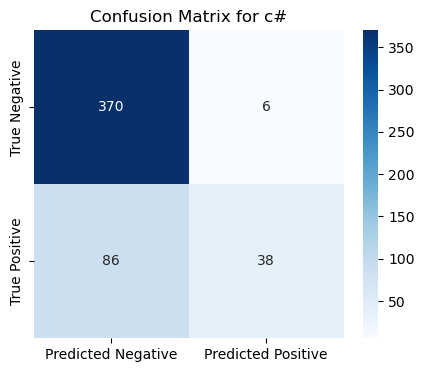

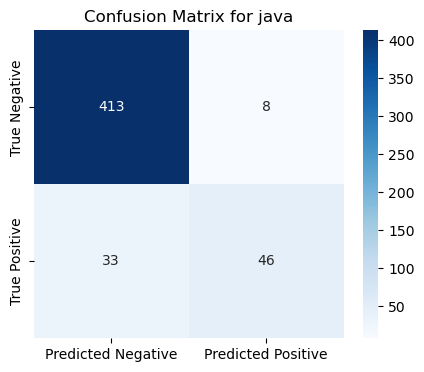

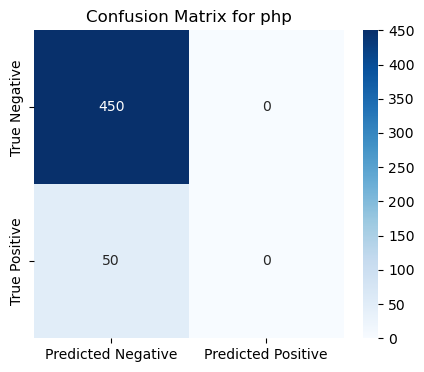

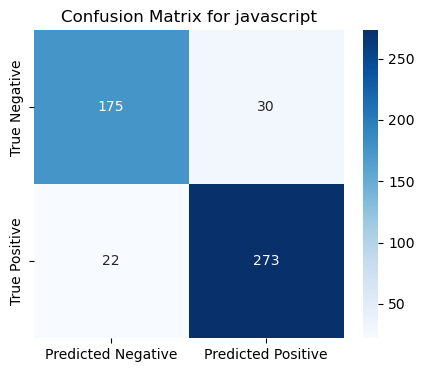

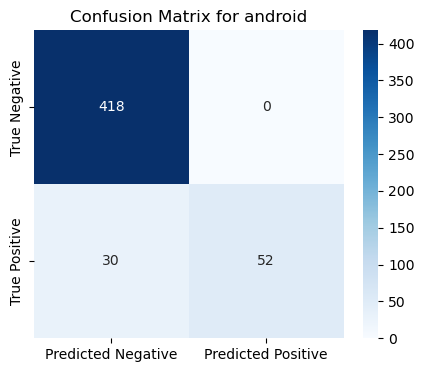

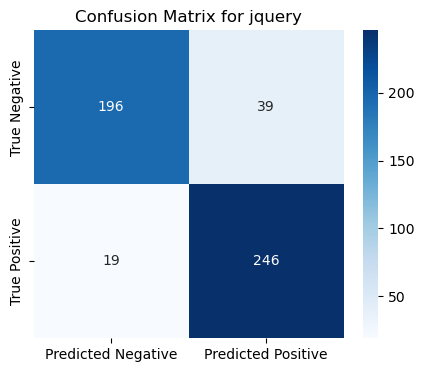

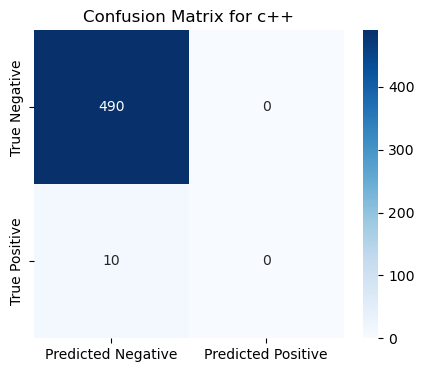

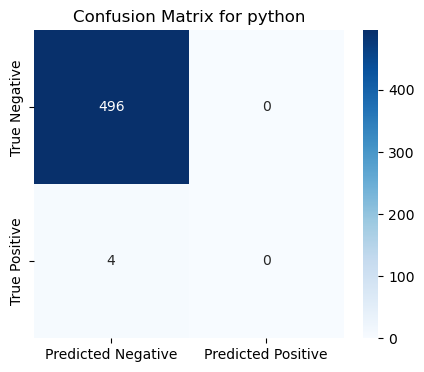

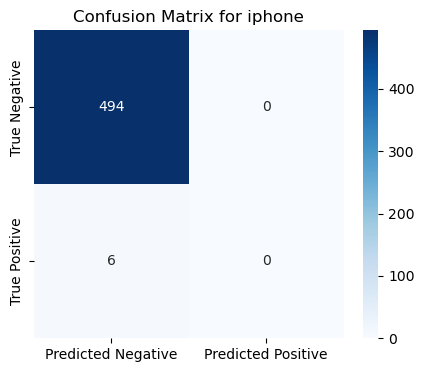

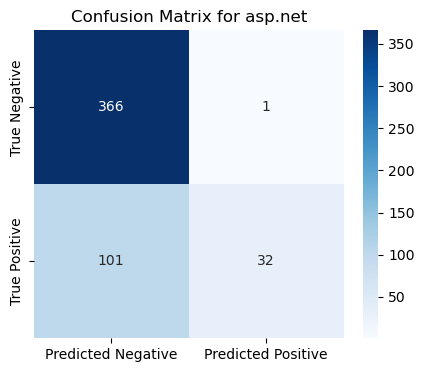

/home/harpreet/mambaforge/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


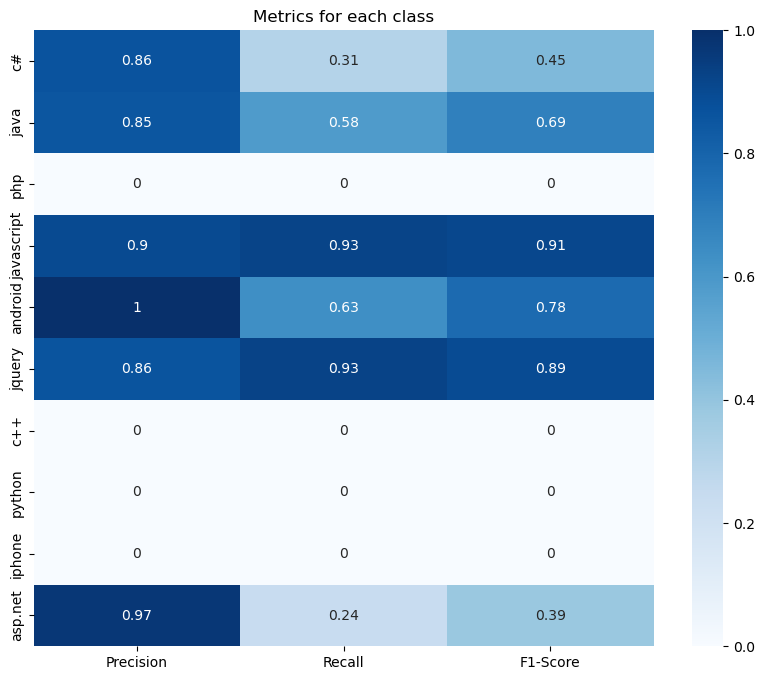

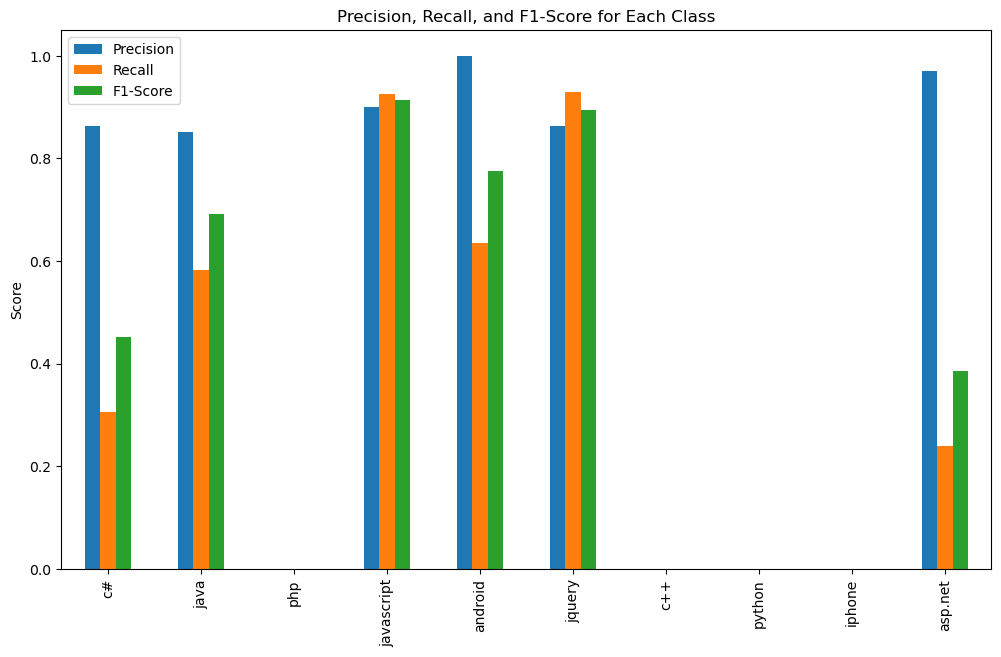

In [108]:
# from sklearn.metrics import multilabel_confusion_matrix, precision_score, recall_score, f1_score

# Sample data
y_true = labels
y_pred = predictions

mcm = multilabel_confusion_matrix(y_true, y_pred)

# 1. Individual Heatmaps
for idx, matrix in enumerate(mcm):
    plt.figure(figsize=(5, 4))
    sns.heatmap(matrix, annot=True, fmt='g', cmap='Blues', 
                xticklabels=['Predicted Negative', 'Predicted Positive'], 
                yticklabels=['True Negative', 'True Positive'])
    plt.title(f'Confusion Matrix for {class_names[idx]}')
    plt.show()

# 2. Aggregate Metrics Heatmap
precision_per_class = precision_score(y_true, y_pred, average=None)
recall_per_class = recall_score(y_true, y_pred, average=None)
f1_per_class = f1_score(y_true, y_pred, average=None)

metrics_df = pd.DataFrame({
    'Precision': precision_per_class,
    'Recall': recall_per_class,
    'F1-Score': f1_per_class
}, index=class_names)

plt.figure(figsize=(10, 8))
sns.heatmap(metrics_df, annot=True, cmap='Blues')
plt.title('Metrics for each class')
plt.show()

# 3. Histogram of Metrics
metrics_df.plot(kind='bar', figsize=(12, 7))
plt.ylabel('Score')
plt.title('Precision, Recall, and F1-Score for Each Class')
plt.show()




In [109]:
wandb.finish()


eval/accuracy_all,▁▄▅▅▅▆▆▇▇▇███
eval/avg_label_accuracy,▁▃▃▃▅▅▆▇▇▇███
eval/loss,█▆▅▅▄▃▂▂▂▁▁▁▁
eval/macro_f1,▁▃▄▄▄▅▆▇▇▇███
eval/micro_f1,▁▃▃▃▅▅▆▇▇▇███
eval/runtime,▃▄▁▁▂▅▄▄▃▄█▆▄
eval/samples_per_second,▆▅██▇▄▅▅▆▅▁▃▅
eval/steps_per_second,▆▅██▇▄▅▅▆▅▁▃▅
train/epoch,▁▁▂▂▂▂▃▃▃▃▄▄▅▅▅▅▆▆▆▆▇▇████
train/global_step,▁▁▂▂▂▂▃▃▃▃▄▄▅▅▅▅▆▆▆▆▇▇████
train/learning_rate,█▇▇▆▅▅▄▄▃▂▂▁


### <font color = 'indianred'> **Check the best saved model**</font>


In [110]:
# After training, let us check the best checkpoint
# We need this for Predictions and Evaluations
best_model_checkpoint_step = trainer.state.best_model_checkpoint.split('-')[-1]
print(f"The best model was saved at step {best_model_checkpoint_step}.")


The best model was saved at step 240.


#  <font color = 'indianred'> **Inference**

## <font color = 'indianred'> **Test Set Evaluation**


In [111]:
test_subset


DatasetDict({
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 500
    })
})

In [112]:
test_subset

DatasetDict({
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 500
    })
})

**NOTE we used ```from evaluate import evaluator``` in imdb dataset. Again this is currently not working for multiclass classification. Hence we will create our own evaluator.**

In [113]:
def evaluator(model, dataset, tokenizer, compute_metrics, batch_size=16):
    """
    Evaluates a model's performance on a given dataset.

    Parameters:
    - model: The trained model to evaluate.
    - dataset: The dataset on which the model will be evaluated.
    - tokenizer: The tokenizer used to preprocess the text data.
    - compute_metrics: A function to compute evaluation metrics.
    - batch_size: Size of batches for evaluation. Default is 16.

    Returns:
    - evaluations: A dictionary containing computed evaluation metrics.
    """

    # Tokenize the dataset and truncate if the tokenized sequence is longer than the model's maximum input length.
    tokenized_dataset= dataset.map(lambda batch: tokenizer(batch["text"], truncation=True), batched=True)

    # Set the format of the tokenized dataset to be compatible with PyTorch.
    tokenized_dataset.set_format(type='torch')

    # Remove the 'text' column from the tokenized dataset as it's no longer needed post-tokenization.
    tokenized_dataset= tokenized_dataset.remove_columns(['text'])

    # Define a collation function that pads tokenized sequences to the same length for batching.
    collate_fn = DataCollatorWithPadding(tokenizer=tokenizer)

    # Initialize a DataLoader to iterate over the tokenized dataset in batches.
    datalaoder = DataLoader(tokenized_dataset, batch_size=batch_size, collate_fn=collate_fn)

    # Put the model in evaluation mode and move it to the GPU.
    model.eval()
    model.to('cuda')

    # Initialize variables to store the model's logits (raw prediction scores) and true labels.
    eval_logits = None
    eval_labels = None

    # Disable gradient calculations for efficient memory usage during evaluation.
    with torch.inference_mode():
        # Iterate over batches from the DataLoader.
        for batch in datalaoder:
            # Prepare the inputs and move them to the GPU.
            inputs = {k: v.to('cuda') for k, v in batch.items() if k != 'labels'}

            # Get the model's predictions for the current batch.
            outputs = model(**inputs)
            logits = outputs.logits
            labels = batch['labels'].to('cuda')

            # Append the logits and labels of the current batch to the accumulating variables.
            if eval_logits is None:
                eval_logits = logits.cpu().numpy()
                eval_labels = labels.cpu().numpy()
            else:
                eval_logits = np.append(eval_logits, logits.cpu().numpy(), axis=0)
                eval_labels = np.append(eval_labels, labels.cpu().numpy(), axis=0)

    # Compute evaluation metrics using the provided compute_metrics function.
    evaluations = compute_metrics((eval_logits, eval_labels))

    return evaluations


In [114]:
evaluations = evaluator(model, test_subset['test'], tokenizer, compute_metrics, batch_size=16)

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [115]:
evaluations

{'macro_f1': 0.842007590266612,
 'micro_f1': 0.9066,
 'accuracy_all': 0.528,
 'avg_label_accuracy': 0.9066000000000001}

##  <font color = 'indianred'> **Pipeline for Predictions**

## <font color = 'indianred'> **Standard Pipeline Class**

In [116]:
# Convert the path to the 'checkpoint-220' inside the 'model_folder' to a string format.
# SEE THE step number for best moel from the section -- Check the best saved model
# This was 220 for me, you might get a different numnber
checkpoint = str(model_folder/'checkpoint-240')

custom_pipeline = pipeline(
    task="text-classification",
    model=checkpoint,
    tokenizer=checkpoint,
    device=0,
    return_all_scores=True)


/home/harpreet/mambaforge/lib/python3.10/site-packages/transformers/pipelines/text_classification.py:105: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


###  <font color = 'indianred'> **Prediction for individual or small list of examples**

In [117]:
sample = test_subset['test']['text'][0]
sample

'super noob question get return integer value method super noob question create method get sharedpreference return know use integer return method method public int getx       return mprefs.getint("x 1   method way allow use integer value'

In [118]:
preds = custom_pipeline(sample)
preds


[[{'label': 'c#', 'score': 0.4554290473461151},
  {'label': 'java', 'score': 0.35206884145736694},
  {'label': 'php', 'score': 0.14302653074264526},
  {'label': 'javascript', 'score': 0.20579169690608978},
  {'label': 'android', 'score': 0.31037673354148865},
  {'label': 'jquery', 'score': 0.14025096595287323},
  {'label': 'c++', 'score': 0.07944697141647339},
  {'label': 'python', 'score': 0.07455291599035263},
  {'label': 'iphone', 'score': 0.062135208398103714},
  {'label': 'asp.net', 'score': 0.4566061794757843}]]

In [119]:
sample = test_split['text'][19]
sample

'use registerclientscriptblock register javascript asp.net 2.0 provide clientscript registerclientscriptblock method register javascript asp.net page issue have pass script locate directory   specifically following syntax work clientscript registerclientscriptblock(this gettype scriptname /dir subdir true   instead drop code page like page say instead display /dir subdir question deal find way drop javascript separate file   go wrong way'

In [120]:
preds = custom_pipeline(sample)
preds

[[{'label': 'c#', 'score': 0.37276408076286316},
  {'label': 'java', 'score': 0.17785318195819855},
  {'label': 'php', 'score': 0.1461712121963501},
  {'label': 'javascript', 'score': 0.4481455087661743},
  {'label': 'android', 'score': 0.14057807624340057},
  {'label': 'jquery', 'score': 0.25296491384506226},
  {'label': 'c++', 'score': 0.04890541732311249},
  {'label': 'python', 'score': 0.05263851210474968},
  {'label': 'iphone', 'score': 0.04742346331477165},
  {'label': 'asp.net', 'score': 0.40666577219963074}]]

### <font color = 'indianred'> **Prediction for large dataset**

In [121]:
predictions = custom_pipeline(test_subset['test']['text'], truncation=True)

In [122]:
predictions

[[{'label': 'c#', 'score': 0.4554290473461151},
  {'label': 'java', 'score': 0.35206884145736694},
  {'label': 'php', 'score': 0.14302653074264526},
  {'label': 'javascript', 'score': 0.20579169690608978},
  {'label': 'android', 'score': 0.31037673354148865},
  {'label': 'jquery', 'score': 0.14025096595287323},
  {'label': 'c++', 'score': 0.07944697141647339},
  {'label': 'python', 'score': 0.07455291599035263},
  {'label': 'iphone', 'score': 0.062135208398103714},
  {'label': 'asp.net', 'score': 0.4566061794757843}],
 [{'label': 'c#', 'score': 0.5293939113616943},
  {'label': 'java', 'score': 0.3397078216075897},
  {'label': 'php', 'score': 0.15534314513206482},
  {'label': 'javascript', 'score': 0.20439989864826202},
  {'label': 'android', 'score': 0.28101596236228943},
  {'label': 'jquery', 'score': 0.13561078906059265},
  {'label': 'c++', 'score': 0.08759883046150208},
  {'label': 'python', 'score': 0.0807935893535614},
  {'label': 'iphone', 'score': 0.07360734790563583},
  {'label

## <font color = 'indianred'> **Custom Pipeline Class**

In [123]:
import numpy as np
from transformers import Pipeline

def sigmoid(logits):
    return 1 / (1 + np.exp(-logits))

class MultiLabelClassificationPipeline(Pipeline):
    def _sanitize_parameters(self, **kwargs):
        preprocess_kwargs = {}
        return preprocess_kwargs, {}, {}

    def preprocess(self, text):       
        tokenized = self.tokenizer(text, return_tensors=self.framework, truncation=True, padding=True, max_length=512)
        return tokenized


    def _forward(self, model_inputs):
        model_inputs = {k: v.to(self.model.device) for k, v in model_inputs.items()}
        return self.model(**model_inputs)


    def postprocess(self, model_outputs):
        logits = model_outputs.logits[0].cpu().numpy()
        probabilities = sigmoid(logits)

        threshold = 0.5
        labels = [self.model.config.id2label[i] for i, prob in enumerate(probabilities) if prob > threshold]

        scores = [prob for prob in probabilities if prob > threshold]
        return {"labels": labels, "scores": scores}


In [124]:
checkpoint = str(model_folder/'checkpoint-240')
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
model.to('cuda')
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

multi_label_pipeline = MultiLabelClassificationPipeline(model=model, tokenizer=tokenizer)


model.device

device(type='cuda', index=0)

###  <font color = 'indianred'> **Prediction for individual or small list of examples**

In [125]:
sample = test_subset['test']['text'][0]
sample

'super noob question get return integer value method super noob question create method get sharedpreference return know use integer return method method public int getx       return mprefs.getint("x 1   method way allow use integer value'

In [126]:
preds = multi_label_pipeline(sample)
preds


{'labels': [], 'scores': []}

In [127]:
sample = test_split['text'][19]
sample

'use registerclientscriptblock register javascript asp.net 2.0 provide clientscript registerclientscriptblock method register javascript asp.net page issue have pass script locate directory   specifically following syntax work clientscript registerclientscriptblock(this gettype scriptname /dir subdir true   instead drop code page like page say instead display /dir subdir question deal find way drop javascript separate file   go wrong way'

In [128]:
preds = multi_label_pipeline(sample)
preds

{'labels': [], 'scores': []}

### <font color = 'indianred'> **Prediction for large dataset**

In [129]:
predictions = multi_label_pipeline(test_subset['test']['text'], truncation=True)

In [130]:
predictions

[{'labels': [], 'scores': []},
 {'labels': ['c#', 'asp.net'], 'scores': [0.5293939, 0.5099318]},
 {'labels': ['javascript', 'jquery'], 'scores': [0.8767403, 0.8376549]},
 {'labels': [], 'scores': []},
 {'labels': ['javascript', 'jquery'], 'scores': [0.8605595, 0.8096176]},
 {'labels': ['javascript', 'jquery'], 'scores': [0.8700941, 0.85147107]},
 {'labels': ['javascript', 'jquery'], 'scores': [0.8706707, 0.81977534]},
 {'labels': ['javascript', 'jquery'], 'scores': [0.8592871, 0.8583615]},
 {'labels': ['java', 'android'], 'scores': [0.57058084, 0.5719891]},
 {'labels': ['javascript'], 'scores': [0.6032006]},
 {'labels': ['javascript', 'jquery'], 'scores': [0.67165107, 0.58905005]},
 {'labels': ['javascript', 'jquery'], 'scores': [0.8495914, 0.7956479]},
 {'labels': ['javascript'], 'scores': [0.6484062]},
 {'labels': ['javascript', 'jquery'], 'scores': [0.8545202, 0.7601077]},
 {'labels': ['javascript', 'jquery'], 'scores': [0.8719719, 0.86113524]},
 {'labels': ['java', 'android'], 'sco